# Libs

In [3]:
# importing sys
import sys

# adding path to **parent folder** of package **WF_SDK** the  to the system path
sys.path.insert(0, '../WaveForms-SDK-Getting-Started-PY-master/WaveForms-SDK-Getting-Started-PY-master')

In [4]:
from WF_SDK import device, scope, wavegen, tools, error   # import instruments
import matplotlib.pyplot as plt   # needed for plotting
from time import sleep            # needed for delays

# Code

## scope, wavegen

- Measurement setup:

  - (AD3 W1/GND  - AD3 1+/1-)

device name: 
device handle: c_long(1)


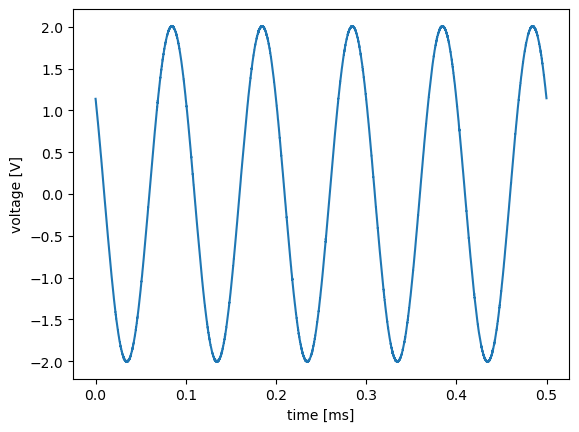

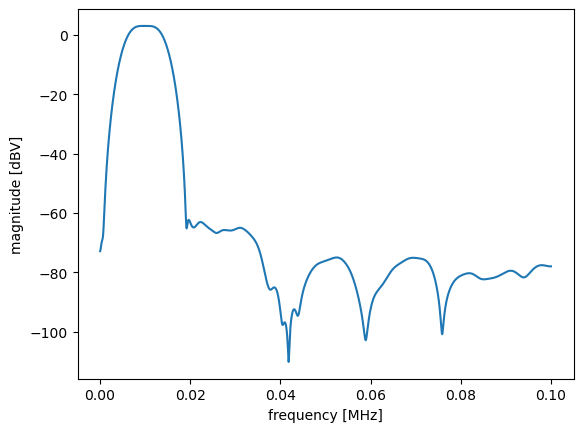

In [ ]:
try:
    # connect to the device
    device_data = device.open()

    """-----------------------------------"""

    print(f"device name: {device_data.name}")
    # It is None, because in the source code `WF_SDK/device.py`, 
    # the defined variable `device_names` does not contain information for the "Analog Discovery 3".
    # However, it is not a problem, because the main definition file:
    # `C:\Program Files (x86)\Digilent\WaveFormsSDK\samples\py\dwfconstants.py` contains information for the "Analog Discovery 3".
    # we can redefine the function to include the this information.

    print(f"device handle: {device_data.handle}")

    # handle devices without analog I/O channels
    if device_data.name != "Digital Discovery":

        # initialize the scope with default settings
        scope.open(device_data)

        # set up triggering on scope channel 1
        scope.trigger(device_data, enable=True, source=scope.trigger_source.analog, channel=1, level=0)

        # generate a 10KHz sine signal with 2V amplitude on channel 1
        wavegen.generate(device_data, channel=1, function=wavegen.function.sine, offset=0, frequency=10e03, amplitude=2)

        sleep(1)    # wait 1 second (to collect data)
                    # must be calculated to avoid overflow the buffer in the acquisition instrument,
                    # in this case, the acquisition instrument is Oscilloscope.
                    # How to calculate the **maximum time the buffer is full**:
                    #   1. we must look at the `scope` instrument:
                    #   2. Look into the function `open` of `scope` in `..\WaveForms-SDK-Getting-Started-PY-master\WaveForms-SDK-Getting-Started-PY-master\WF_SDK\scope.py`:
                    #   3. By default, the buffer (`buffer_size`) is set to be maximum. 
                    #       This buffer max size can be consulted in the text file resulted from running the `..\WaveForms-SDK-Getting-Started-PY-master\WaveForms-SDK-Getting-Started-PY-master\test_device_info.py`
                    #       In the resulted text file, maximum buffer size is found in section "Analog input information:.. maximum buffer size"; or in the reference `../README.md` - Reference [0].
                    #       Therefore, we have max buf size = 16384 samples / channel
                    #   4. By default, the sampling frequency (`sampling_frequency`) is 20e6 Hz = 20e6 samples/s
                    #   5. Based on 3. and 4., we know after maximum (buffer_szie / sample_frequency) second, 
                    #       the triggered channel in oscilloscope for recording the data will be full !  
                    #   6. Based on 5., in this case, the maximum time to make the buffer full is (16384 * 1e3 /20e6) = 0.8 ms,
                    #       Therefore, eventhough the sleep time is set to be 1 second, the figure below only shows signal (drawn from the buffer)
                    #       within the window duration of around 0.5 ms.

        # record data with the scopeon channel 1
        buffer = scope.record(device_data, channel=1)

        # limit displayed data size
        length = len(buffer)
        if length > 10000:
            length = 10000
        buffer = buffer[0:length]

        # generate buffer for time moments
        time = []
        for index in range(len(buffer)):
            time.append(index * 1e03 / scope.data.sampling_frequency)   # convert time to ms

        # plot
        plt.plot(time, buffer)
        plt.xlabel("time [ms]")
        plt.ylabel("voltage [V]")
        plt.show()

        """-----------------------------------"""

        # compute the spectrum from 0Hz to 100KHz
        start_frequency = 0
        stop_frequency = 100e03
        spectrum = tools.spectrum(buffer, tools.window.flat_top, scope.data.sampling_frequency, start_frequency, stop_frequency)

        # calculate frequency domain data
        frequency = []
        length = len(spectrum)
        step = (stop_frequency - start_frequency) / (length - 1)
        for index in range(length):
            frequency.append((start_frequency + index * step) / 1e06)   # convert frequency in MHz
        
        # plot
        plt.plot(frequency, spectrum)
        plt.xlabel("frequency [MHz]")
        plt.ylabel("magnitude [dBV]")
        plt.show()

        """-----------------------------------"""

        # reset the scope
        scope.close(device_data)

        # reset the wavegen
        wavegen.close(device_data)

    """-----------------------------------"""

    # close the connection
    device.close(device_data)

except error as e:
    print(e)
    # close the connection
    device.close(device.data)

In [8]:
# connect to the device
device_data = device.open()
print(device_data)
device.close(device.data)

<class 'WF_SDK.device.data'>
